***Data Prep***

In [ ]:
#basic modules
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#regression model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#performance indicators
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
from google.colab import files

In [ ]:
df_august = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_08.csv')
df_september = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_09.csv')
df_october = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_10.csv')

In [ ]:
df_august['Month'] = 0
df_september['Month'] = 1
df_october['Month'] = 2

In [ ]:
frames = [df_august, df_september, df_october]
df = pd.concat(frames)

In [ ]:
df_live, df_backup = train_test_split(df,test_size=0.3, random_state=42)

In [ ]:
num_cols = df_live.select_dtypes([np.number]).columns
df_nums = df_live[num_cols].reset_index(drop=True)

# Dropping rows which contain missing values
df_clean = df_nums.dropna()

In [ ]:
X = df_clean.loc[:,df_nums.columns != 'price']
y = df_clean['price'].values

In [ ]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)
X_normalized_df_no_nan = X_normalized_df.dropna(axis=0)

In [ ]:
selected_columns_2 = ['squareMeters', 'longitude']
selected_columns_3 = ['squareMeters', 'longitude', 'poiCount']
selected_columns_5 = ['squareMeters', 'longitude', 'poiCount', 'rooms', 'centreDistance']
selected_columns_7 = ['squareMeters', 'longitude', 'poiCount', 'rooms', 'centreDistance', 'clinicDistance', 'kindergartenDistance']

X2=X_normalized_df[selected_columns_2]
X3=X_normalized_df[selected_columns_3]
X5=X_normalized_df[selected_columns_5]
X7=X_normalized_df[selected_columns_7]

***Regression***

In [ ]:
#parameters
degree = [2,3,5,7]
dataToChoose = [X2,X3,X5,X7]
r_values = 1 #repetitions
random_state_main = 42 #main random state

#creating arrays to save data
RMSE_saved_in_each_iter = [[[0 for _ in range(r_values)] for _ in range(len(dataToChoose))] for _ in range(len(degree))]
R2_score_in_each_iter = [[[0 for _ in range(r_values)] for _ in range(len(dataToChoose))] for _ in range(len(degree))]
coefficients_in_each_iter = [[[0 for _ in range(r_values)] for _ in range(len(dataToChoose))] for _ in range(len(degree))]
state_in_each_iter = [[[0 for _ in range(r_values)] for _ in range(len(dataToChoose))] for _ in range(len(degree))]

In [ ]:
def FitPolynomial(degree, dataToChoose, r_values, random_state_main):


  #main loop
  for k in range(r_values):
    for i in range(len(degree)):
      for j in range(len(dataToChoose)):


        #creating our polynomial features. We want to test different number of features for each of the 4 different nb of degrees
        poly2 = PolynomialFeatures(degree=degree[i], include_bias=True)

        #fitting the data into a model and transforming it into a form that is more suitable for the model
        poly_features = poly2.fit_transform(dataToChoose[j])

        #splitting the data
        X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=random_state_main)
        X1_train1, X1_validation, y1_train1, y1_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state=random_state_main)

        #creating and fitting the model
        poly_reg_model = LinearRegression(fit_intercept=True)
        poly_reg_model.fit(X_train, y_train)

        #testing the results
        poly_reg_y_predicted = poly_reg_model.predict(X1_validation)
        poly_reg_rmse = np.sqrt(mean_squared_error(y1_validation, poly_reg_y_predicted))

        #saving the data into arrays
        RMSE_saved_in_each_iter[i][j][k]=poly_reg_rmse
        R2_score_in_each_iter[i][j][k]=r2_score(poly_reg_y_predicted, y1_validation)
        coefficients_in_each_iter[i][j][k] = poly_reg_model.coef_
        state_in_each_iter[i][j][k] = random_state_main

  #returning output
  return RMSE_saved_in_each_iter, R2_score_in_each_iter, coefficients_in_each_iter, state_in_each_iter

In [ ]:
result1, result2, result3, result4 = FitPolynomial([2,3,5,7], [X2,X3,X5,X7], 1, 42)
# print(result1)
# print(result2)
# print(result3)
# print(result4)

In [ ]:
#averaging the results (transforming 4x4x10 into 4x4 with each value beaing a mean of the 10 previously in the k dimmension)
average_RMSE = np.mean(RMSE_saved_in_each_iter, axis=2)
average_R2_score = np.mean(R2_score_in_each_iter, axis=2)

***Saving the results***

In [ ]:
#saving results so we don't have to rerun everything
#savetxt('/content/R2_score_mean.csv', average_R2_score, delimiter=',')
#files.download('/content/R2_score_mean.csv')
#savetxt('/content/average_RMSE.csv', average_RMSE, delimiter=',')
#files.download('/content/average_RMSE.csv')

***Heat map***

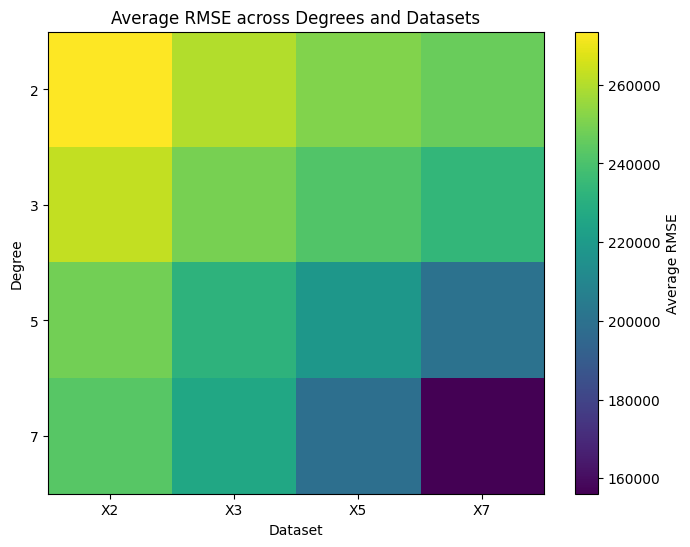

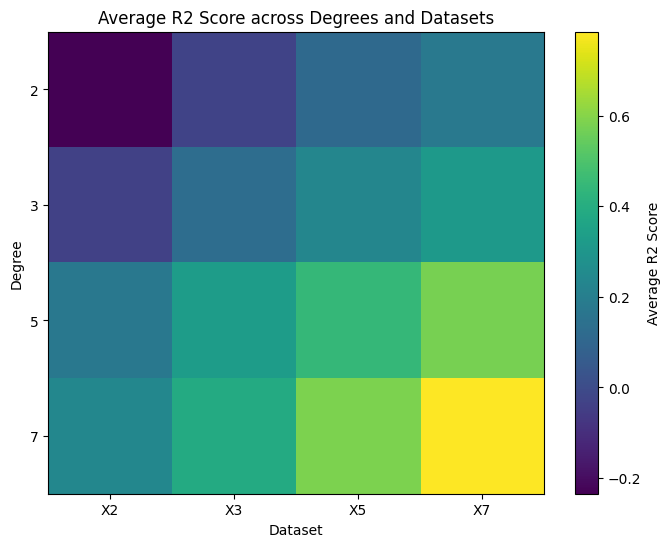

In [ ]:
# Plotting average RMSE
plt.figure(figsize=(8, 6))
plt.imshow(average_RMSE, cmap='viridis', aspect='auto')
plt.colorbar(label='Average RMSE')
plt.xlabel('Dataset')
plt.ylabel('Degree')
plt.title('Average RMSE across Degrees and Datasets')
plt.xticks(np.arange(len(dataToChoose)), ['X2', 'X3', 'X5', 'X7'])
plt.yticks(np.arange(len(degree)), degree)
plt.show()

# Plotting average R2 score
plt.figure(figsize=(8, 6))
plt.imshow(average_R2_score, cmap='viridis', aspect='auto')
plt.colorbar(label='Average R2 Score')
plt.xlabel('Dataset')
plt.ylabel('Degree')
plt.title('Average R2 Score across Degrees and Datasets')
plt.xticks(np.arange(len(dataToChoose)), ['X2', 'X3', 'X5', 'X7'])
plt.yticks(np.arange(len(degree)), degree)
plt.show()

***Extracting informations from statistical data***

In [ ]:
#finding idexes of the min and max of RMSE matrix

#converting to NumPy array
RMSE_saved_in_each_iter_num = np.array(RMSE_saved_in_each_iter)

min_index_RMSE = np.unravel_index(np.argmin(RMSE_saved_in_each_iter_num), RMSE_saved_in_each_iter_num.shape)
max_index_RMSE = np.unravel_index(np.argmax(RMSE_saved_in_each_iter_num), RMSE_saved_in_each_iter_num.shape)

In [ ]:
#finding idexes of the min and max of R2 matrix

#converting to NumPy array
R2_score_in_each_iter_num = np.array(R2_score_in_each_iter)

min_index_R2 = np.unravel_index(np.argmin(R2_score_in_each_iter_num), R2_score_in_each_iter_num.shape)
max_index_R2 = np.unravel_index(np.argmax(R2_score_in_each_iter_num), R2_score_in_each_iter_num.shape)

In [ ]:
print('Min RMSE: ', min_index_RMSE)
print('Max RMSE: ', max_index_RMSE)
print('Min R2: ', min_index_R2)
print('Max R2: ', max_index_R2)

Min RMSE:  (3, 3, 0)
Max RMSE:  (0, 0, 0)
Min R2:  (0, 0, 0)
Max R2:  (3, 3, 0)


In [ ]:
RMSE_saved_in_each_iter_num[3][3][0]

156081.3823722964

The model is severly underfitted for the simplest configuration (2 features, 2 degrees).

The supposed best solution is the most complex configuration (7 features, 7 degrees)

We will now test the best configuration on the testing dataset:

In [ ]:
def CheckPerformanceTraining(degree_num, dataToChoose_num, random_state_main):
  #Chcecking performance of the best configuration on the testing dataset

  poly2 = PolynomialFeatures(degree=degree[degree_num], include_bias=True)

  #fitting the data into a model and transforming it into a form that is more suitable for the model
  poly_features = poly2.fit_transform(dataToChoose[dataToChoose_num])

  #splitting the data
  X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=random_state_main)
  X1_train1, X1_validation, y1_train1, y1_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state=random_state_main)

  #creating and fitting the model
  poly_reg_model = LinearRegression(fit_intercept=True)
  poly_reg_model.fit(X_train, y_train)

  #testing the results
  poly_reg_y_predicted = poly_reg_model.predict(X_test)
  poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
  r2_score_result=r2_score(poly_reg_y_predicted, y_test)
  return poly_reg_rmse, r2_score_result

In [ ]:
#testing 7,7 config
result1, result2 = CheckPerformanceTraining(3, 3, 42)
print(result1)
print(result2)

1688323.268359545
0.02497213463777992


The RMSE is significantly higher on the testing dataset, this indicates that overfitting occured.

This result shows us the limitations of the Polynomial regression model. We are on the verge of overfitting the regressor if we continue to increase the degree of the polynomial.

Therefore the best model is either 5 features, 7 degrees or 7 features, 5 degrees. We shall now see which of them produced better results on the validation dataset.

In [ ]:
#chechikng which is better

print('RMSE f,d 5,7: ', RMSE_saved_in_each_iter[3][2][0])
print('RMSE f,d 7,5: ', RMSE_saved_in_each_iter[2][3][0])
print('R2 f,d 5,7: ', R2_score_in_each_iter[3][2][0])
print('R2 f,d 5,7: ', R2_score_in_each_iter[2][3][0])

RMSE f,d 5,7:  198741.30078441233
RMSE f,d 7,5:  200540.69179315073
R2 f,d 5,7:  0.5842619590517424
R2 f,d 5,7:  0.5745869027868751


5 features and 7 degrees is our best solution, checking results on testing dataset

In [ ]:
#testing 5,7 config
result1, result2 = CheckPerformanceTraining(2, 3, 42)
print(result1)
print(result2)


200668.89321972686
0.5570629705361692
